In [1]:
import gzip
import math
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix # To build sparse feature matrices, if you like
import pandas as pd
from gensim.parsing.preprocessing import STOPWORDS

import html
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

This takes a 1.5 mins to run

In [3]:
# allRatings = [l for l in parse("ratebeer.json.gz")]
rawRatings = [l for l in parse("sampled_ratebeer.json.gz")][0] # sampled has 300,000 reviews

# Sample and compress dataset (ALREADY RAN DONT RUN)

In [4]:
# # Random sample the dataset because it's too big

# sampleSize = 300000
# sampledAllRatings = random.sample(ratings, sampleSize)

In [5]:
# import json

# with open("sampled_ratebeer.json", "w") as f:
#     json.dump(sampledAllRatings, f)

In [6]:
# import gzip
# import shutil

# # File paths
# input_file = 'sampled_ratebeer.json'      # Your existing JSON file
# output_file = 'sampled_ratebeer.json.gz'  # Desired compressed file

# # Compress the JSON file
# with open(input_file, 'rb') as f_in:
#     with gzip.open(output_file, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print(f"Compressed {input_file} to {output_file}")


# Clean data

Check missing labels (beer/style)

In [4]:
df = pd.DataFrame(rawRatings)

In [5]:
df.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,Dogfish Head Midas Touch Golden Elixir,7293,198,9,Traditional Ale,3/5,6/10,4/5,6/10,15/20,1172188800,chef201atc,Clear copper pour with a white bubbly head tha...
1,Lost Abbey Red Barn Ale,64608,7043,6.7,Saison,4/5,8/10,3/5,7/10,14/20,1318204800,jgb9348,Hazy blonde coloured body with a hay glow and ...
2,Grand River 1913 Traditional,125081,8650,4.5,Klsch,3/5,7/10,3/5,7/10,15/20,1277164800,JesseM,On tap at GRs 3rd Anniversary tasting. Taps a ...
3,Sterkens White Ale,4568,527,4.7,Belgian White (Witbier),3/5,6/10,3/5,6/10,12/20,1264204800,markas101,"33 cl bottle, Fargo, ND, USA. Pale yellow colo..."
4,Delafield Pewaukee Porter,19652,2877,5.5,Porter,3/5,5/10,3/5,5/10,9/20,1113696000,robertsreality,Dark Brown Coloring with Light Tan Head. Dust...


In [6]:
df.shape

(300000, 13)

In [7]:
df.dtypes

beer/name             object
beer/beerId           object
beer/brewerId         object
beer/ABV              object
beer/style            object
review/appearance     object
review/aroma          object
review/palate         object
review/taste          object
review/overall        object
review/time           object
review/profileName    object
review/text           object
dtype: object

In [8]:
df.isna().sum() / len(df)

beer/name             0.0
beer/beerId           0.0
beer/brewerId         0.0
beer/ABV              0.0
beer/style            0.0
review/appearance     0.0
review/aroma          0.0
review/palate         0.0
review/taste          0.0
review/overall        0.0
review/time           0.0
review/profileName    0.0
review/text           0.0
dtype: float64

In [9]:
# correcting data type
def ratingToInt(rating):
    if type(rating) == int:
        return rating
    
    top, bottom = rating.split('/')
    return int(top)

# Remove no ABV beers
cleanedDf = df[df['beer/ABV'] != '-']
cleanedDf.reset_index()
cleanedDf['beer/ABV'] = cleanedDf['beer/ABV'].apply(float)         

cleanedDf['review/appearance'] = cleanedDf['review/appearance'].apply(ratingToInt)
cleanedDf['review/aroma'] = cleanedDf['review/aroma'].apply(ratingToInt) 
cleanedDf['review/palate'] = cleanedDf['review/palate'].apply(ratingToInt) 
cleanedDf['review/taste'] = cleanedDf['review/taste'].apply(ratingToInt) 
cleanedDf['review/overall'] = cleanedDf['review/overall'].apply(ratingToInt)


# Removing escape sequences from labels
cleanedDf['beer/style'] = cleanedDf['beer/style'].apply(html.unescape)

# https://stackoverflow.com/questions/8115261/how-to-remove-all-the-escape-sequences-from-a-list-of-strings
escapeChars = ''.join([chr(char) for char in range(1, 32)])
translator = str.maketrans('', '', escapeChars)

# Remove escape characters from `review/text`
def removeEscapeChars(text: str) -> str:
    return text.translate(translator)

cleanedDf['review/text'] = cleanedDf['review/text'].apply(removeEscapeChars)

C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\881224829.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['beer/ABV'] = cleanedDf['beer/ABV'].apply(float)
C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\881224829.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/appearance'] = cleanedDf['review/appearance'].apply(ratingToInt)
C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\881224829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

# EDA

In [10]:
# Distribution of ratings in dataset
def plotRatingDist(ratingKey):
    x = cleanedDf[ratingKey]
    minRating, maxRating = x.min(), x.max()
    bins = [i for i in range(minRating, maxRating + 1)]
    plt.hist(x, bins, rwidth=0.9)
    plt.title(f"Distribution of {ratingKey}")
    plt.xlabel(ratingKey)
    plt.ylabel("Proportion")

In [11]:
# How many styles of beers are there?
cleanedDf[['beer/style']].describe()

,beer/style
count,285700
unique,89
top,India Pale Ale (IPA)
freq,18043


,review/appearance
count,285700.0
mean,3.0
std,1.0
min,1.0
25%,3.0
50%,3.0
75%,4.0
max,5.0


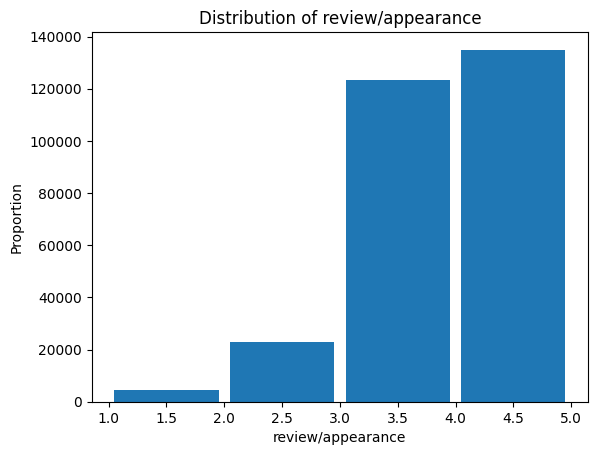

In [12]:
plotRatingDist('review/appearance')
cleanedDf[['review/appearance']].describe().round(0)

,review/aroma
count,285700.0
mean,6.0
std,2.0
min,1.0
25%,6.0
50%,7.0
75%,7.0
max,10.0


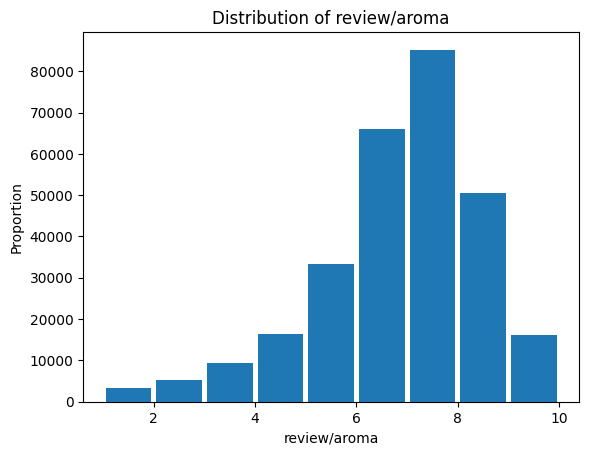

In [13]:
plotRatingDist('review/aroma')
cleanedDf[['review/aroma']].describe().round(0)

,review/palate
count,285700.0
mean,3.0
std,1.0
min,1.0
25%,3.0
50%,3.0
75%,4.0
max,5.0


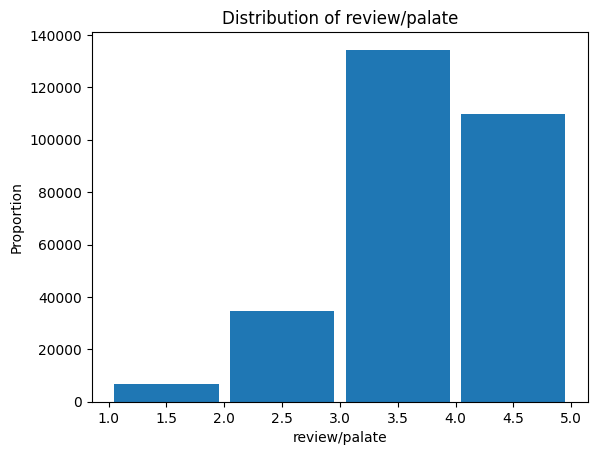

In [14]:
plotRatingDist('review/palate')
cleanedDf[['review/palate']].describe().round(0)

,review/taste
count,285700.0
mean,6.0
std,2.0
min,1.0
25%,6.0
50%,7.0
75%,8.0
max,10.0


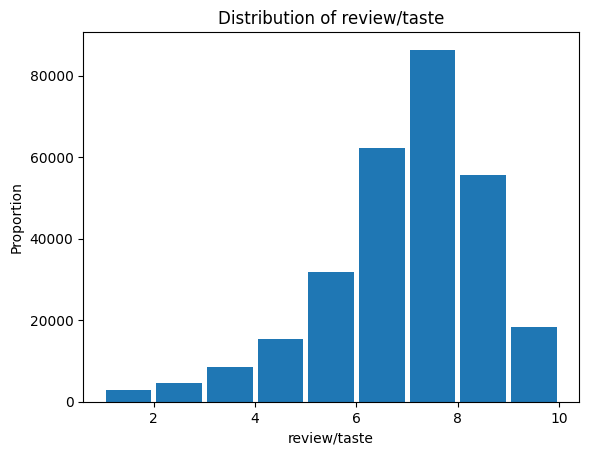

In [15]:
plotRatingDist('review/taste')
cleanedDf[['review/taste']].describe().round(0)

,review/overall
count,285700.0
mean,13.0
std,3.0
min,1.0
25%,12.0
50%,14.0
75%,15.0
max,20.0


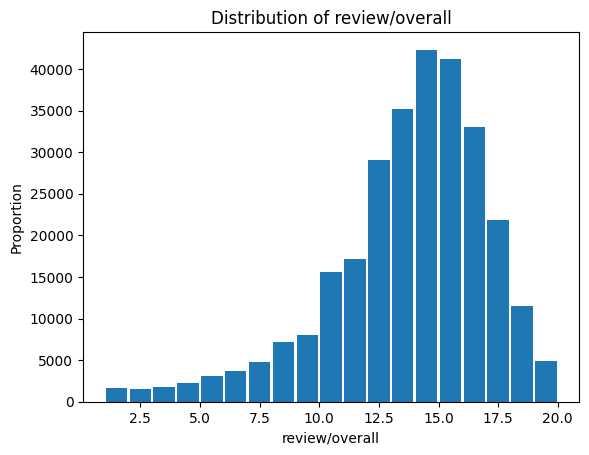

In [16]:
plotRatingDist('review/overall')
cleanedDf[['review/overall']].describe().round(0)

Review text length

In [17]:
cleanedDf['review/length'] = cleanedDf['review/text'].apply(len)

C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\342384755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/length'] = cleanedDf['review/text'].apply(len)


In [18]:
cleanedDf[['review/length']].describe().round(2)

,review/length
count,285700.00
mean,307.65
std,215.31
min,0.00
25%,176.00
50%,253.00
75%,374.00
max,8449.00


In [19]:
dfByRating = cleanedDf.groupby('review/overall')['review/length'].mean()

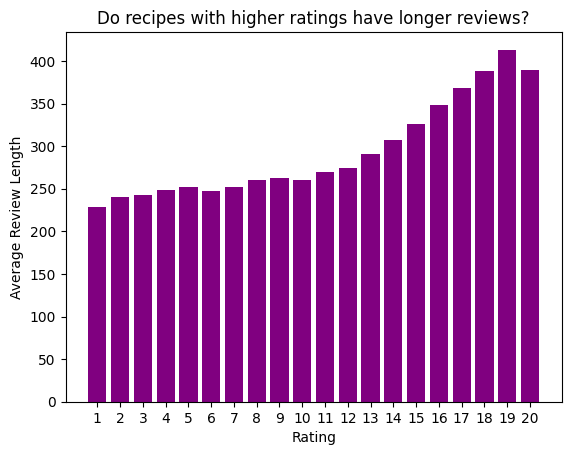

In [20]:
plt.bar(dfByRating.index, dfByRating.values, color = 'purple')
plt.xticks(dfByRating.index)
plt.title('Do recipes with higher ratings have longer reviews?')
plt.xlabel('Rating');
plt.ylabel('Average Review Length'); # no.

In [21]:
wordCount = defaultdict(int)
for i, rating in cleanedDf.iterrows():
    for w in rating['review/text'].split():
        wordCount[w] += 1

len(wordCount)

375488

### Per Flavor

The `beer_mapping.json` file contains mappings for beer types to flavor labels generated by ChatGPT to group beers into flavors. A beer can be in multiple flavors.

In [22]:
import json

with open('beer_mapping.json') as f:
    beerFlavorMapping = json.load(f)

def findFlavor(style: str) -> str:
    for flavor in beerFlavorMapping:
        if style in beerFlavorMapping[flavor]:
            return flavor

beerFlavorMapping.keys()

dict_keys(['malty', 'hoppy', 'crisp', 'roasty', 'fruity/spicy', 'sour', 'rich/hearty', 'smoky', 'specialty'])

In [23]:
cleanedDf['beer/flavor'] = cleanedDf['beer/style'].apply(findFlavor)

C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\1548089217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['beer/flavor'] = cleanedDf['beer/style'].apply(findFlavor)


Identify the counts for each style of beer

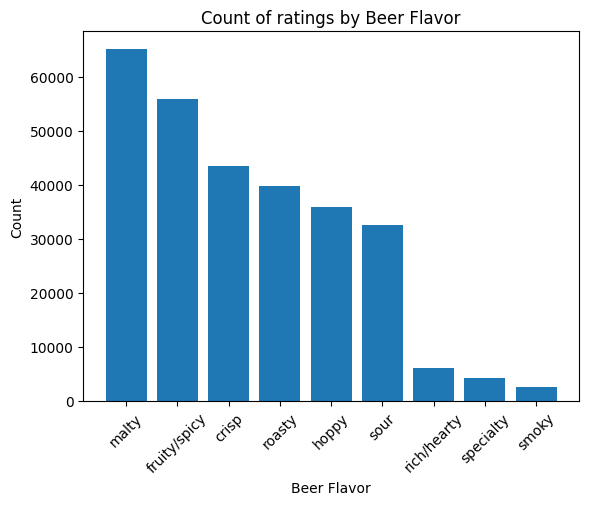

In [24]:
graph = plt.bar(cleanedDf['beer/flavor'].unique(), cleanedDf['beer/flavor'].value_counts())
plt.title('Count of ratings by Beer Flavor')
plt.xlabel('Beer Flavor')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Creates a df with no outliers
def removeOutlierFromDF(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    df['beer/ABV'] = df[feature].apply(float)

    # Clean the outliers out
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    noOutlierDF = df[(lower <= df[feature]) & (df[feature] <= upper)]
    return noOutlierDF

In [26]:
# Plots a bar graph grouped by beer flavor
def plotBarByFlavor(df: pd.DataFrame, y: str, title=''):
    sns.boxplot(data=df, x='beer/flavor', y=y)
    plt.title(title)
    plt.xlabel('Beer Flavor')
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.show()

ABV Distribution

C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\2268683075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beer/ABV'] = df[feature].apply(float)


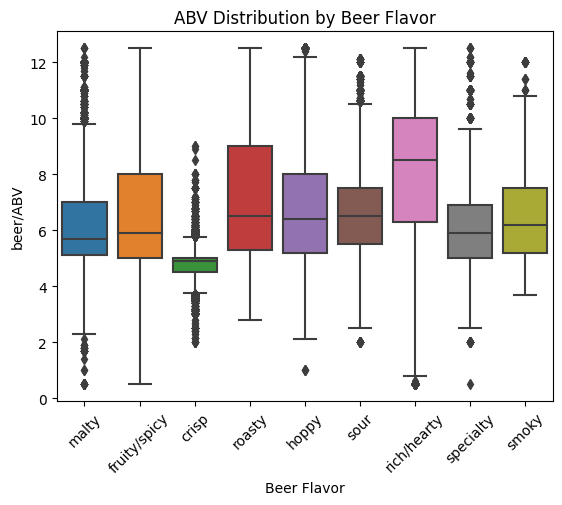

In [27]:
noOutlierABVDF = removeOutlierFromDF(cleanedDf, 'beer/ABV')
plotBarByFlavor(noOutlierABVDF, 'beer/ABV', 'ABV Distribution by Beer Flavor')

Review Text Length

In [28]:
cleanedDf['review/text length'] = cleanedDf['review/text'].apply(len)
noOutlierLengthDF = removeOutlierFromDF(cleanedDf, 'review/text length')

C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\1423692617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/text length'] = cleanedDf['review/text'].apply(len)
C:\Users\edwar\AppData\Local\Temp\ipykernel_7976\2268683075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beer/ABV'] = df[feature].apply(float)


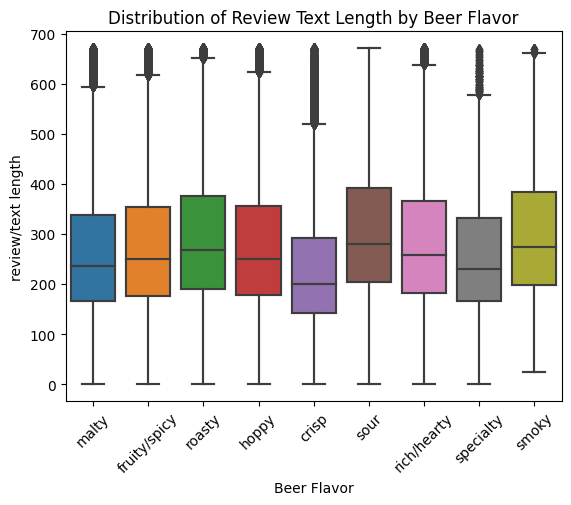

In [29]:
sns.boxplot(data=noOutlierLengthDF, x='beer/flavor', y='review/text length')
plotBarByFlavor(noOutlierLengthDF, 'review/text length', 'Distribution of Review Text Length by Beer Flavor')

# Get features
We get only the features we want to use ('beer/name', 'review/text')

In [30]:
# Only contains features we will use
featureDf = cleanedDf[['beer/name', 'review/text', 'beer/flavor']]
featureDf.head()

,beer/name,review/text,beer/flavor
0,Dogfish Head Midas Touch Golden Elixir,Clear copper pour with a white bubbly head tha...,malty
1,Lost Abbey Red Barn Ale,Hazy blonde coloured body with a hay glow and ...,fruity/spicy
2,Grand River 1913 Traditional,On tap at GRs 3rd Anniversary tasting. Taps a ...,crisp
3,Sterkens White Ale,"33 cl bottle, Fargo, ND, USA. Pale yellow colo...",fruity/spicy
4,Delafield Pewaukee Porter,Dark Brown Coloring with Light Tan Head. Dust...,roasty


# Split dataset

In [31]:
splitRatio = 0.95
splitIndex = int(len(featureDf) * splitRatio)
ratingsTrain = featureDf.iloc[:splitIndex]
ratingsTest = featureDf.iloc[splitIndex:]

ratingsTrain.reset_index()
ratingsTest.reset_index()

len(ratingsTrain), len(ratingsTest)

(271415, 14285)

In [32]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
numbers = set([str(i) for i in range(10)])
for i, rating in featureDf.iterrows():  
  r = ''.join([c for c in rating['review/text'].lower() if not c in punctuation and c not in numbers])
  for w in r.split():
    if w not in STOPWORDS:
      wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [33]:
words = [x[1] for x in counts[:2000]]

In [34]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

### Baseline (Only Predict Most Frequent)

In [ ]:
from sklearn.dummy import DummyClassifier

# Baseline model that predicts the most frequent class
baseline_model = DummyClassifier(strategy='most_frequent')

baseline_X = [0] * len(ratingsTrain)
baseline_y = [d for d in ratingsTrain['beer/flavor'].values]

baseline_Xtest = [0] * len(ratingsTest)
baseline_yTest = [d for d in ratingsTest['beer/flavor'].values]

baseline_model.fit(baseline_X, baseline_y)
baseline_accuracy = baseline_model.score(baseline_Xtest, baseline_yTest)

In [147]:
baseline_accuracy

0.23549177458872944

### Unigram

In [38]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation and c not in numbers])
    for w in r.split():
        if w in words and w not in STOPWORDS:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Takes a while to run

In [40]:
X = [feature(d) for i, d in ratingsTrain.iterrows()]
y = [d for d in ratingsTrain['beer/flavor'].values]

In [41]:
mod = linear_model.LogisticRegression(C=1)
mod.fit(X, y)
theta = mod.coef_
predictions = mod.predict(X)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
ratingsTrain['beer/flavor'].values

array(['malty', 'fruity/spicy', 'crisp', ..., 'fruity/spicy',
       'rich/hearty', 'roasty'], dtype=object)

In [43]:
correct = [p == l for p,l in zip(predictions, ratingsTrain['beer/flavor'].values)]
sum(correct) / len(correct)

0.6507378000478972

In [44]:
Xtest = [feature(d) for i, d in ratingsTest.iterrows()]
ytest = [d['beer/flavor'] for i, d in ratingsTest.iterrows()]

In [46]:
testPredictions = mod.predict(Xtest)

In [47]:
correct = [p == l for p,l in zip(testPredictions, ratingsTest['beer/flavor'].values)]
sum(correct) / len(correct)

0.6382219110955548

Heatmap

In [127]:
from sklearn.metrics import confusion_matrix

def plot_cm(ytest, ypred, mod):
    cm = confusion_matrix(ytest, ypred, labels=mod.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mod.classes_, yticklabels=mod.classes_)

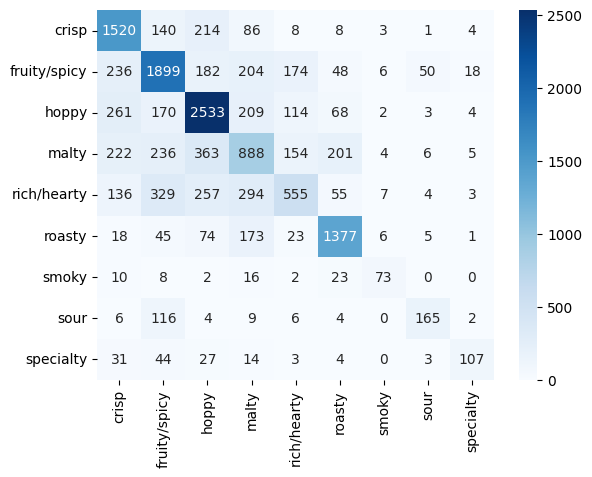

In [ ]:
plot_cm(ytest, testPredictions, mod)

AUC Curve

In [128]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [129]:
def plot_auc(Xtest, ytest, mod):
    y_bin = label_binarize(ytest, classes=mod.classes_)
    yprob = mod.predict_proba(Xtest)
    
    fpr, tpr, _ = roc_curve(y_bin.ravel(), yprob.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Create a plot for each class
    plt.figure()

    # Loop through each class and plot its ROC curve
    for i in range(len(mod.classes_)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], yprob[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot each class ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'Class {mod.classes_[i]} (AUC = {roc_auc:.2f})')

    # Plot diagonal line for random performance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc='lower right')
    plt.show()

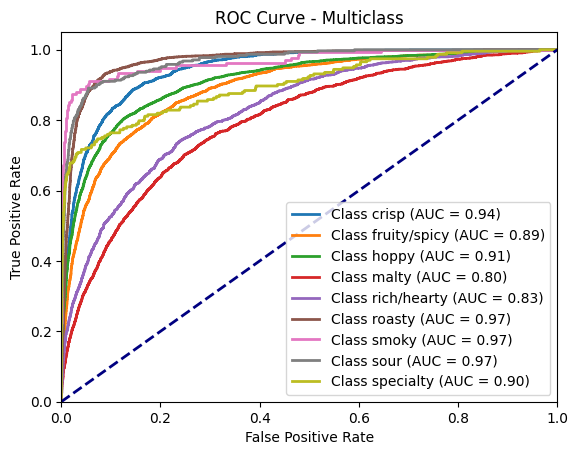

In [164]:
plot_auc(Xtest, ytest, mod)

Precision Recall Curve

In [130]:
from sklearn.metrics import precision_recall_curve

In [131]:
def plot_precision_recall(Xtest, ytest, mod):
    y_bin = label_binarize(ytest, classes=mod.classes_)
    yprob = mod.predict_proba(Xtest)

    # Plot precision-recall curve for each class
    for i in range(len(mod.classes_)):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], yprob[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {mod.classes_[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Multiclass')
    plt.legend(loc='best')
    plt.show()

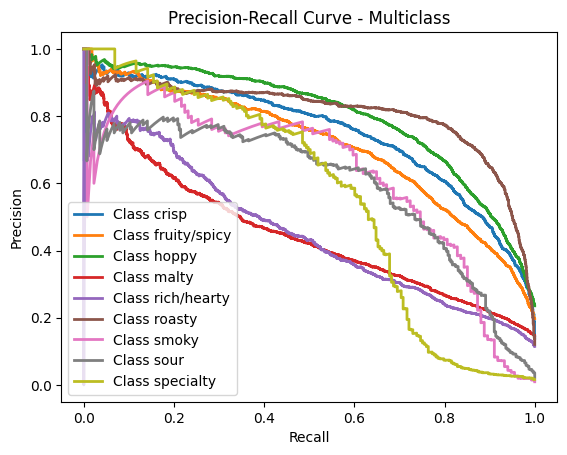

In [167]:
plot_precision_recall(Xtest, ytest, mod)

In [132]:
# See which words are most important for each class
def getImportantWords(flavor: str, n: int, mod) -> list[str]:
    
    # Get index of flavor class
    if sum(np.isin(mod.classes_, flavor)) > 0:
        flavorIndex = np.where(mod.classes_ == flavor)[0][0]
    else:
        return []
    
    coeffs = [(w,c) for w,c in zip(words, mod.coef_[flavorIndex][:-1])][:n]
    coeffs.sort(key=lambda x:x[1], reverse=True)
    return coeffs

In [ ]:
# importantWordsByFlavor = {}

# for flavor in mod.classes_:
#     importantWordsByFlavor[flavor] = getImportantWords(flavor, 20, mod)

In [ ]:
# with open("2000_reviewonly_important_words.json", "w") as f:
#     json.dump(importantWordsByFlavor, f, indent=2)

### Unigram STEMMING

In [68]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
numbers = set([str(i) for i in range(10)])
stemmer = PorterStemmer()
for i, rating in featureDf.iterrows():  
  r = ''.join([c for c in rating['review/text'].lower() if not c in punctuation and c not in numbers])
  for w in r.split():
    if w not in STOPWORDS:
      w = stemmer.stem(w)
      wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [69]:
words = [x[1] for x in counts[:2000]]

In [78]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [82]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation and c not in numbers])
    for w in r.split():
        if w not in STOPWORDS:
            w = stemmer.stem(w)
            if w in words:
                feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Takes a while to run

In [83]:
X = [feature(d) for i, d in ratingsTrain.iterrows()]
y = [d for d in ratingsTrain['beer/flavor'].values]

In [84]:
mod = linear_model.LogisticRegression(C=1)
mod.fit(X, y)
theta = mod.coef_
predictions = mod.predict(X)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
correct = [p == l for p,l in zip(predictions, ratingsTrain['beer/flavor'].values)]
sum(correct) / len(correct)

0.6547206307683805

In [86]:
Xtest = [feature(d) for i, d in ratingsTest.iterrows()]
ytest = [d['beer/flavor'] for i, d in ratingsTest.iterrows()]

In [87]:
testPredictions = mod.predict(Xtest)

In [88]:
correct = [p == l for p,l in zip(testPredictions, ratingsTest['beer/flavor'].values)]
sum(correct) / len(correct)

0.6414420721036052

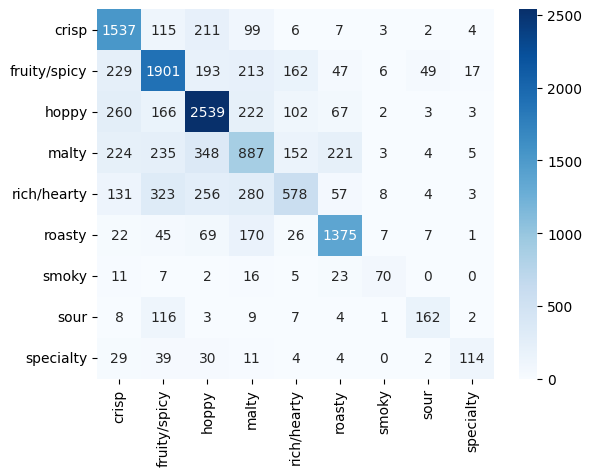

In [89]:
plot_cm(ytest, testPredictions, mod)

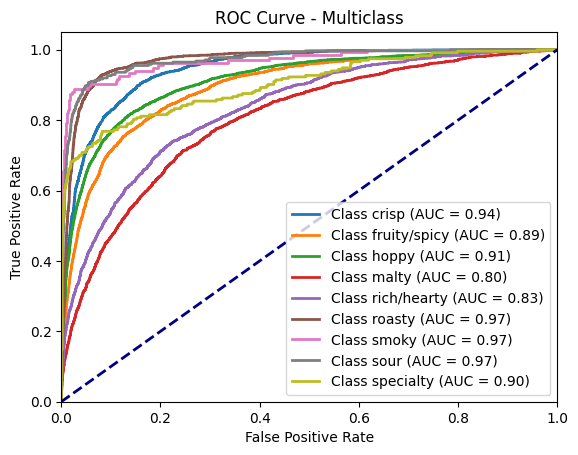

In [90]:
plot_auc(Xtest, ytest, mod)

Precision Recall Curve

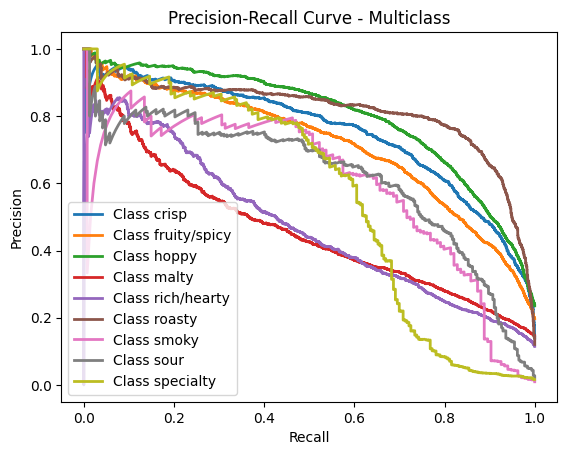

In [91]:
plot_precision_recall(Xtest, ytest, mod)

In [ ]:
# See which words are most important for each class
def getImportantWords(flavor: str, n: int, mod) -> list[str]:
    
    # Get index of flavor class
    if sum(np.isin(mod.classes_, flavor)) > 0:
        flavorIndex = np.where(mod.classes_ == flavor)[0][0]
    else:
        return []
    
    coeffs = [(w,c) for w,c in zip(words, mod.coef_[flavorIndex][:-1])][:n]
    coeffs.sort(key=lambda x:x[1], reverse=True)
    return coeffs

In [ ]:
# importantWordsByFlavor = {}

# for flavor in mod.classes_:
#     importantWordsByFlavor[flavor] = getImportantWords(flavor, 20, mod)

In [ ]:
# with open("2000_reviewonly_important_words.json", "w") as f:
#     json.dump(importantWordsByFlavor, f, indent=2)

### N grams

In [ ]:
# wordCount = defaultdict(int)
# punctuation = set(string.punctuation)
# numbers = set([str(i) for i in range(10)])
# for i, rating in featureDf.iterrows():
#     r = ''.join([c for c in rating['review/text'].lower() if not c in punctuation and c not in numbers])
#     ws = r.split()
#     ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
#     ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
#     ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
#     ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
#     for w in ws + ws2 + ws3 + ws4 + ws5:
#         if w not in STOPWORDS:
#             wordCount[w] += 1

# counts = [(wordCount[w], w) for w in wordCount]
# counts.sort()
# counts.reverse()

In [ ]:
# def nGram_feature(datum):
#     feat = [0]*len(words)
#     r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation and c not in numbers])
#     ws = r.split()
#     ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
#     ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
#     ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
#     ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
#     for w in ws + ws2 + ws3 + ws4 + ws5:
#         if w in words and w not in STOPWORDS:
#             feat[wordId[w]] += 1
#     feat.append(1) #offset
#     return feat

In [ ]:
# nGram_X = [nGram_feature(d) for i, d in ratingsTrain.iterrows()]
# nGram_y = [d for d in ratingsTrain['beer/flavor'].values]

In [ ]:
# nGram_mod = linear_model.LogisticRegression(C=1)
# nGram_mod.fit(nGram_X, nGram_y)
# nGram_theta = nGram_mod.coef_

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# nGram_predictions = nGram_mod.predict(nGram_X)

# correct = [p == l for p,l in zip(nGram_predictions, ratingsTrain['beer/flavor'].values)]
# sum(correct) / len(correct)

0.6502109315992115

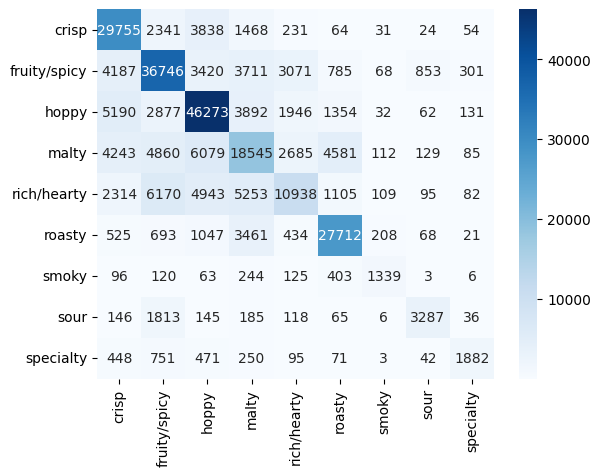

In [ ]:
# plot_cm(nGram_y, nGram_predictions, nGram_mod)

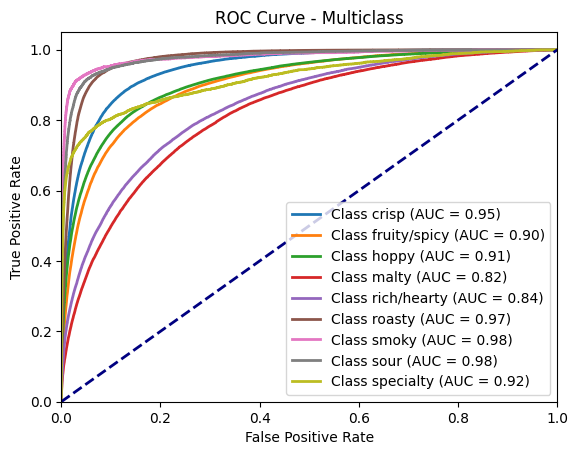

In [ ]:
# plot_auc(nGram_X, nGram_y, nGram_mod)

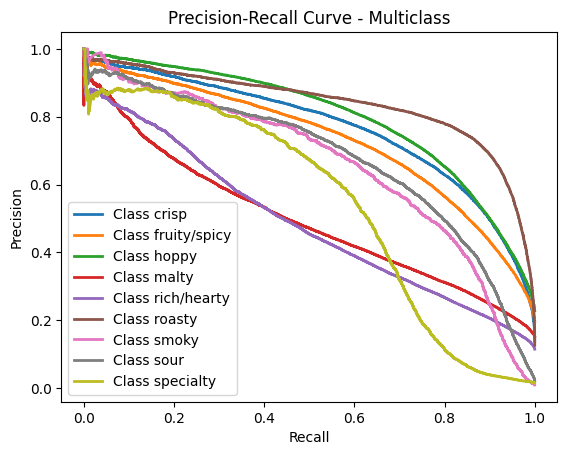

In [ ]:
# plot_precision_recall(nGram_X, nGram_y, nGram_mod)

### TF-IDF

In [112]:
words = [x[1] for x in counts[:5000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [113]:
df = defaultdict(int)
for i, d in featureDf.iterrows():
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation and c not in numbers])
    for w in set(r.split()):
        if w not in STOPWORDS:
            df[w] += 1

In [114]:
rev = featureDf.iloc[0] # Query review

In [115]:
tf = defaultdict(int)
r = ''.join([c for c in rev['review/text'].lower() if not c in punctuation and c not in numbers])
for w in r.split():
    # Note = rather than +=, different versions of tf could be used instead
    if w not in STOPWORDS:
        tf[w] = 1
    
tfidf = dict(zip(words,[tf[w] * math.log10(len(featureDf) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log10(len(featureDf) / df[w]) for w in words]

In [116]:
def tfidf_feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation and c not in numbers])
    tokens = r.split()
    for w in tokens:
        if w in wordSet and w not in STOPWORDS:
            feat[wordId[w]] += 1 * math.log10(len(ratingsTrain) / df[w])
    feat.append(1) #offset
    return feat

In [117]:
nf = len(tfidf_feature(featureDf.iloc[0]))

#Sparse matrix
X = lil_matrix((len(featureDf), nf))

for i in range(len(featureDf)):
    if not (i % 1000):
        print(i)
    x = tfidf_feature(featureDf.iloc[i])
    for j in range(nf):
        if x[j]:
            X[i,j] = x[j]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [118]:
y = [f for f in featureDf['beer/flavor'].values]

In [119]:
Xtrain = X[:splitIndex]
ytrain = y[:splitIndex]
Xtest = X[splitIndex:]
ytest = y[splitIndex:]

In [120]:
dfidf_mod = linear_model.LogisticRegression(C=1)
dfidf_mod.fit(Xtrain, ytrain)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [121]:
dfidf_pred = dfidf_mod.predict(Xtest)

In [122]:
correct = dfidf_pred == ytest
sum(correct) / len(correct)

0.6359117955897795

In [123]:
len(words)

5000

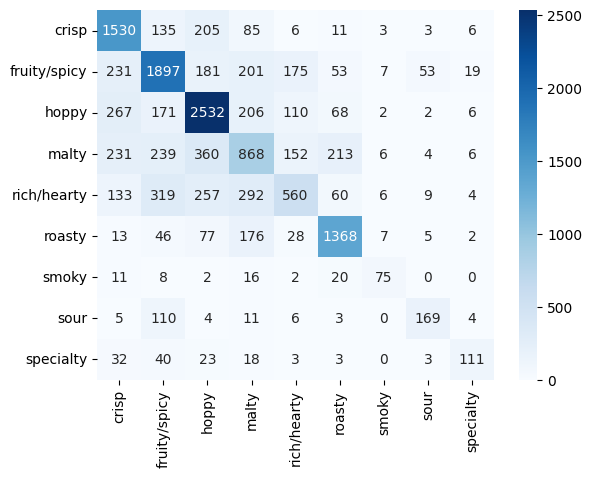

In [104]:
plot_cm(ytest, dfidf_pred, dfidf_mod)

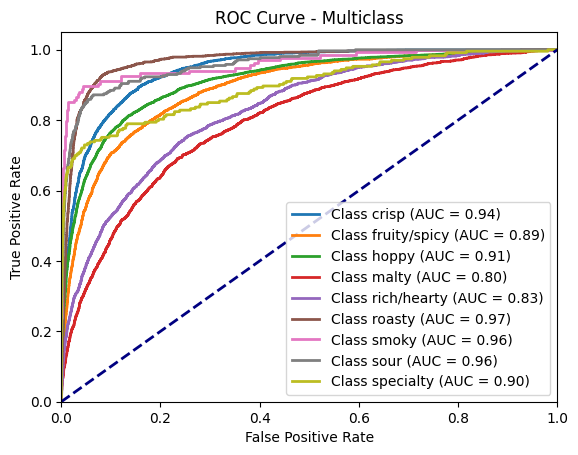

In [105]:
plot_auc(Xtest, ytest, dfidf_mod)

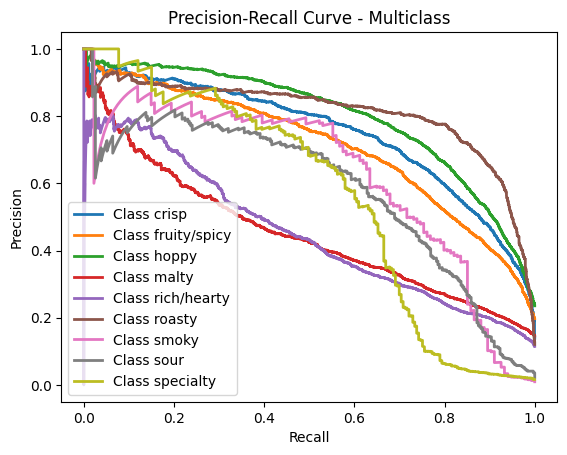

In [106]:
plot_precision_recall(Xtest, ytest, dfidf_mod)

In [ ]:
importantWordsByFlavor = {}

for flavor in dfidf_mod.classes_:
    importantWordsByFlavor[flavor] = getImportantWords(flavor, 20, dfidf_mod)

In [111]:
with open("dfidf_2000_reviewonly_important_words.json", "w") as f:
    json.dump(importantWordsByFlavor, f, indent=2)

### Sklearn LG

In [35]:
sklearn_X = [text for text in featureDf['review/text'].values]
sklearn_y = [flavor for flavor in featureDf['beer/flavor'].values]

In [36]:
sklearn_X_train = sklearn_X[:splitIndex]
sklearn_y_train = sklearn_y[:splitIndex]
sklearn_X_test = sklearn_X[splitIndex:]
sklearn_y_test = sklearn_y[splitIndex:]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(fit_intercept=False, max_iter=1500, verbose=True))
], verbose=True)

pipeline.fit(sklearn_X_train, sklearn_y_train)
y_pred = pipeline.predict(sklearn_X_test)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=  38.2s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 8.6min


In [38]:
correct = y_pred == sklearn_y_test
sum(correct) / len(correct)

0.6632831641582079

In [ ]:
sklearn_lg_mod = pipeline.named_steps['classifier']
sklearn_vectorizer = pipeline.named_steps['vectorizer']

In [163]:
# Access the vectorized input (transformed features)
X_train_transformed = sklearn_vectorizer.transform(sklearn_X_train)
X_test_transformed = sklearn_vectorizer.transform(sklearn_X_test)

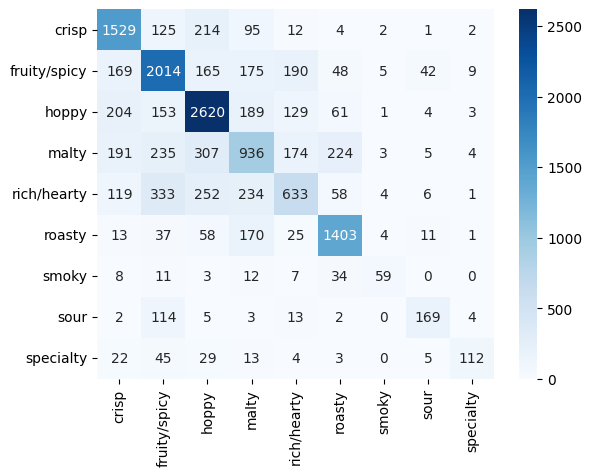

In [164]:
plot_cm(sklearn_y_test, y_pred, sklearn_lg_mod)

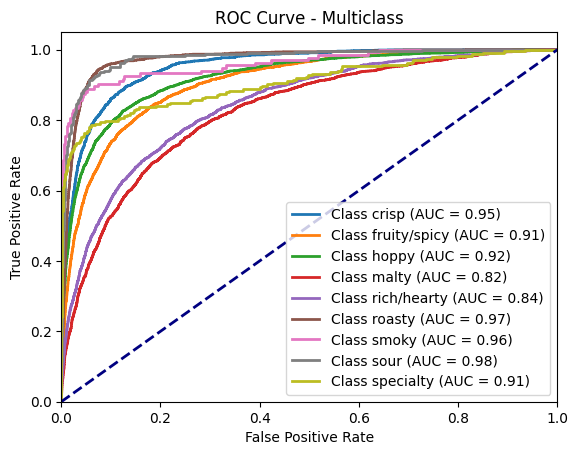

In [165]:
plot_auc(X_test_transformed, sklearn_y_test, sklearn_lg_mod)

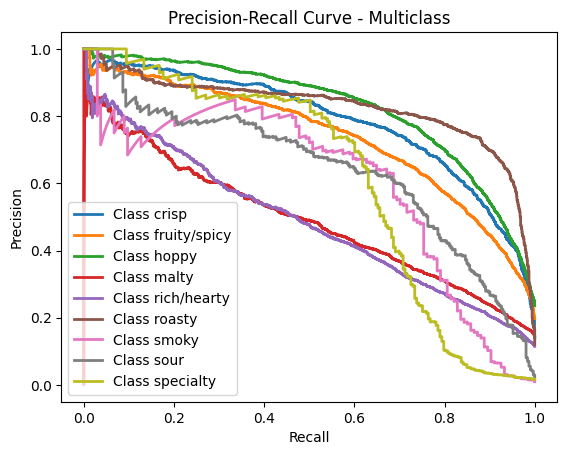

In [166]:
plot_precision_recall(X_test_transformed, sklearn_y_test, sklearn_lg_mod)

In [145]:
importantWordsByFlavor = {}

for flavor in sklearn_lg_mod.classes_:
    importantWordsByFlavor[flavor] = getImportantWords(flavor, 20, sklearn_lg_mod)

In [146]:
with open("sklearn_lg_2000_reviewonly_important_words.json", "w") as f:
    json.dump(importantWordsByFlavor, f, indent=2)

### Support Vector Machine

In [91]:
from sklearn.svm import LinearSVC

pipeline = Pipeline([
    ('classifier', LinearSVC())
], verbose=True)

pipeline.fit(X_train_transformed, sklearn_y_train)
y_pred = pipeline.predict(X_test_transformed)


c:\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Pipeline] ........ (step 1 of 1) Processing classifier, total=  29.0s


In [92]:
correct = y_pred == sklearn_y_test
sum(correct) / len(correct)

NameError: name 'y_pred' is not defined

In [93]:
sklearn_scv_mod = pipeline.named_steps['classifier']

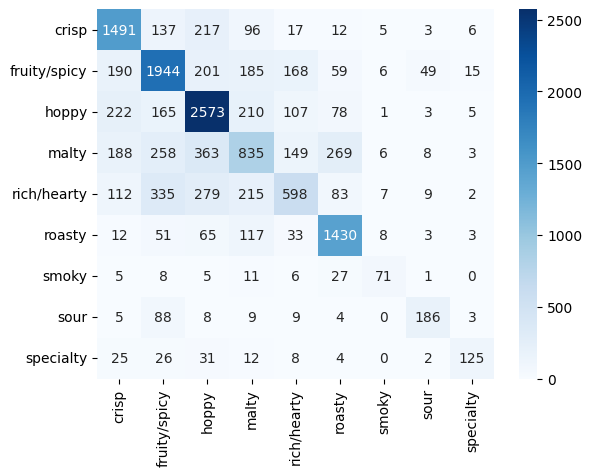

In [94]:
plot_cm(sklearn_y_test, y_pred, sklearn_scv_mod)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SGDClassifier(loss='log_loss'))
])

pipeline.fit(sklearn_X_train, sklearn_y_train)
y_pred = pipeline.predict(sklearn_X_test)

In [101]:
correct = y_pred == sklearn_y_test
sum(correct) / len(correct)

0.6216310815540778

### COMBINE ALL

In [54]:
# Get the longest 10 reviews
mergedDf = pd.DataFrame()

In [55]:
featureDf['text_length'] = featureDf['review/text'].str.len()

C:\Users\edwar\AppData\Local\Temp\ipykernel_37400\2730739149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureDf['text_length'] = featureDf['review/text'].str.len()


In [58]:
sorted_df = featureDf.sort_values(by=['beer/name', 'text_length'], ascending=False)

In [60]:
sorted_df

,beer/name,review/text,beer/flavor,text_length
164223,von Raven Pilsener,"Overly carbonated; lightish body, herbal hop n...",crisp,224
86187,von Raven Pilsener,Can 50 cl. Pours a clear yellow with a decent ...,crisp,213
69272,von Raven Pilsener,Clear golden with a small white head. Malty no...,crisp,134
675,von Raven Pilsener,"NIC elabel, but the taste is not that interest...",crisp,111
52730,von Raven Pilsener,Bottle.Clear yellow coloured with a white head...,crisp,108
...,...,...,...,...
34151,10 Barrel Apocalypse IPA,Sampled in a 22oz bottle. Pours deep brownish ...,hoppy,215
268839,10 Barrel Apocalypse IPA,"A great IPA, big and solid hop profile mostly ...",hoppy,137
7779,&#40;Oude&#41; Kwaremont,Clear light amber coloured beer with small whi...,fruity/spicy,205
290624,&#40;Oude&#41; Kwaremont,"Dark malty nose, sugars, light acidity. Dark a...",fruity/spicy,114


In [61]:
sorted_df[sorted_df['beer/name'] == 'von Raven Pilsener']['review/text'][:10].values

array(['Overly carbonated; lightish body, herbal hop notes.  Maybe there is something in the air in Hamburg, but this didnt seem to have the kind of hops youd expect in a north German pilsner (and neither did the Jever I had there).',
       'Can 50 cl. Pours a clear yellow with a decent white head. The nose is discreetly malty. The body is thin with only a little maltiness and a whiff of metal. Ends dry. A thin if not exactly bad discount Pils. 100910',
       'Clear golden with a small white head. Malty nose with hints of caramel. Flavor was fairly dry with malt and grassy hops. Finished dry.',
       'NIC elabel, but the taste is not that interesting. Just another lager beer, with some hopy taste and good foam.',
       'Bottle.Clear yellow coloured with a white head.Aroma of malts and fruits.Flavour of malts, fruits and grain.',
       'Pale yellow body with small white head. Nose of fresh hops. Some malt in the flavor, hay like hops.',
       'Golden coloured. Grainy aroma. Sweet 

In [67]:
mergedDf = pd.DataFrame(featureDf['beer/name'].unique(), columns=['beer/name'])

def getTopTenLenghts(name, n=2):
    topTen = sorted_df[sorted_df['beer/name'] == name]['review/text'][:n].values
    return " ".join(topTen)

mergedDf['merged_text'] = mergedDf['beer/name'].apply(getTopTenLenghts)

KeyboardInterrupt: 

In [135]:
mergedDf = pd.DataFrame(columns=["beer/name", "merged_text", "beer/flavor"])

In [138]:
mergedDf.loc[-1] = [1,1,1]

In [139]:
mergedDf

,beer/name,merged_text,beer/flavor
-1,1,1,1


In [118]:
mergedDf = pd.DataFrame(featureDf['beer/name'].unique())
mergedDf['merged text'] = ""

for i, review in featureDf.iterrows():
    mergedDf['merged text'] += " " + review['review/text']

KeyboardInterrupt: 

64233